In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from itertools import product 

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
df = pd.read_csv('data_month_T72024_maidn_fnb.csv')
df['based_month'] = pd.to_datetime(df['based_month'])


In [3]:
df = df.set_index('based_month')

In [8]:
df

,retailer_id,gmv
based_month,,
2022-01-01,45967,50957698
2022-02-01,45967,44331700
2022-03-01,45967,51899800
2022-04-01,45967,60789100
2022-05-01,45967,65760800
...,...,...
2024-03-01,500552289,0
2024-04-01,500552289,0
2024-05-01,500552289,405000


## TEST MODEL

2024-05-01    8.562797e+07
2024-06-01    8.893371e+07
2024-07-01    9.218973e+07
2024-08-01    8.955783e+07
2024-09-01    9.086680e+07
2024-10-01    8.576710e+07
2024-11-01    9.387089e+07
2024-12-01    9.245479e+07
2025-01-01    9.576053e+07
2025-02-01    9.901654e+07
2025-03-01    9.638465e+07
2025-04-01    9.769361e+07
2025-05-01    9.259392e+07
Freq: MS, dtype: float64


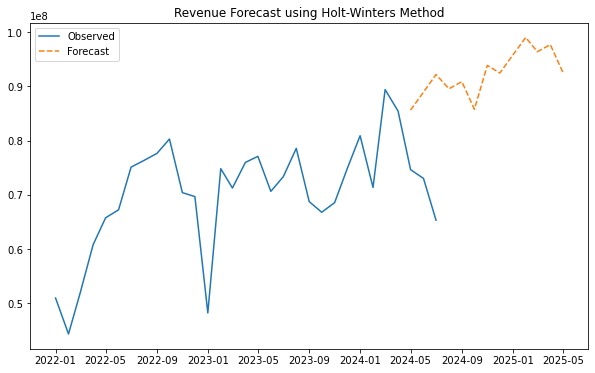

In [9]:
df_test = df[df['retailer_id'] == 45967]
train_data_test = df_test.iloc[:-3]
test_data_test = df_test.iloc[-3:]
# Fit the model
model = ExponentialSmoothing(train_data_test['gmv'], seasonal='add',trend='add', seasonal_periods=7)
fit = model.fit()

# Make predictions
forecast = fit.forecast(steps=13)
# print(df_test[['gmv']])
print(forecast)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_test.index, df_test['gmv'], label='Observed')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title('Revenue Forecast using Holt-Winters Method')
plt.show()


## HOLT-WINTER MODEL

In [14]:
# Viết function tìm ra best param 
def finding_best_param(data, seasonal_period, param_grid):
    optimal_params = {}
    train_data = data.iloc[:-3]
    test_data = data.iloc[-3:]

    best_mse = np.inf 
    best_param = None 
    best_period = None
    for period in seasonal_period:
        for param in param_grid:
            seasonal_param, trend_param = param
            try:
                model = ExponentialSmoothing(train_data['gmv'], seasonal= seasonal_param, trend= trend_param, seasonal_periods=period)
                result = model.fit() 
                forecast = result.forecast(steps=len(test_data))
                mse = mean_squared_error(test_data['gmv'], forecast)
                if mse < best_mse:
                    best_mse = mse 
                    best_param = param
                    best_period = period
                # print('seasonal_periods {} with param {} as mse: {}'.format(period, param, mse))
            except ValueError as error:
                continue
    # print('-------------------------------------------------------')    
    # print('seasonal_periods {} with param {} is the best which has lowest mse: {}'.format(best_period, best_param, best_mse))
    optimal_params[best_period] = best_param
    return optimal_params

In [15]:
customer_best_param = {}
seasonal_param = ['add','mul']
trend_param = ['add','mul']
period = list(range(2,13)) # hiện tại chỉ set được max seasonal_period = 6 , lớn hơn thì lỗi do data k đủ chu kỳ vụ mùa

error_retailers = []

param_grid = list(product(seasonal_param, trend_param))
for retailer_id, retailer_data in df.groupby('retailer_id'):
    try:
        best_param = finding_best_param(retailer_data, period, param_grid)
        customer_best_param[retailer_id] = best_param
        print(f'Finish finding the best param for {retailer_id}')
    except ValueError as error:
        print("ValueError occurred for retailer_id {}: {}".format(retailer_id, error))
        error_retailers.append(retailer_id)
        continue
    

Finish finding the best param for 4119


In [16]:
def hold_winter_model(data, retailer_id, optimal_param):
    # Filter dataset
    data = data[data['retailer_id'] == retailer_id]
    # Apply model
    for period, param in optimal_param.items():
        seasonal_period = period 
        param = param
        model = ExponentialSmoothing(data['gmv'][:-3], seasonal=param[0], trend=param[1], seasonal_periods=seasonal_period)
        results = model.fit()
        forecast = results.forecast(steps=13)
    # Saving result as dataframe
    results_df = pd.DataFrame(forecast.items()) 
    results_df = results_df.rename(columns={0 : 'Date', 1: 'GMV'})
    # results_df = results_df[1:]
    results_df['retailer_id'] = retailer_id
    return results_df


In [17]:
customer_best_param

{4119: {4: ('mul', 'mul')}}

In [18]:
forecast_ret = pd.DataFrame()
for retailer_id, optimal_param in customer_best_param.items():
    result = hold_winter_model(df, retailer_id, optimal_param)
    forecast_ret = pd.concat([forecast_ret, result], ignore_index=True)
    print("Finish retailer_id {}".format(retailer_id))

Finish retailer_id 4119


In [202]:
# forecast_ret.to_csv('hold_winter_12T_hungvt_ver3.csv')

In [19]:
forecast_ret

,Date,GMV,retailer_id
0,2024-05-01,7.043354e+08,4119
1,2024-06-01,3.858232e+08,4119
2,2024-07-01,4.445813e+08,4119
3,2024-08-01,3.507589e+08,4119
4,2024-09-01,6.055303e+08,4119
5,2024-10-01,3.316994e+08,4119
6,2024-11-01,3.822149e+08,4119
7,2024-12-01,3.015540e+08,4119
8,2025-01-01,5.205858e+08,4119
9,2025-02-01,2.851682e+08,4119


# WALK-FORWARD VALIDATION

In [12]:
seasonal_param = ['add','mul']
trend_param = ['add','mul']
period = list(range(2,13)) # hiện tại chỉ set được max seasonal_period = 6 , lớn hơn thì lỗi do data k đủ chu kỳ vụ mùa

error_retailers = []

param_grid = list(product(seasonal_param, trend_param, period))

In [15]:
df_test

,retailer_id,gmv
based_month,,
2022-01-01,45967,50957698
2022-02-01,45967,44331700
2022-03-01,45967,51899800
2022-04-01,45967,60789100
2022-05-01,45967,65760800
2022-06-01,45967,67225600
2022-07-01,45967,75103250
2022-08-01,45967,76339750
2022-09-01,45967,77633150


In [11]:
# Viết function tìm ra best param 
def finding_best_param(data, param_grid):
    best_model = None
    best_mse = np.inf 
    best_params = {} 
    #Walk-forward validation settings
    n_train = 12
    n_records = len(data)
    for param in param_grid:
        seasonal_param, trend_param, seasonal_period = param
        try:
            mse_list = []
            #Walk-forward validation - Expanding window
            for i in range(n_train, n_records-2):
                train_data, test_data = df_test[0:i], df_test[i:i+3]
                model = ExponentialSmoothing(train_data['gmv'], seasonal= seasonal_param, trend= trend_param, seasonal_periods=seasonal_period)
                result = model.fit() 
                forecast = result.forecast(steps=len(test_data))
                mse = mean_squared_error(test_data['gmv'], forecast)
                mse_list.append(mse)
            avg_mse = np.mean(mse_list)
            print(f"The param {param} has average of mse: {avg_mse}")
            # comparing mse
            if avg_mse < best_mse:
                best_mse = avg_mse 
                best_params = {'trend': trend_param, 'seasonal': seasonal_param, 'seasonal_periods': seasonal_period}
                best_model = model

        except Exception as error:
            print(f"Failed with parameters trend={trend_param}, seasonal={seasonal_param}, seasonal_periods={seasonal_period}")
            continue
    return best_params, best_mse, best_model

In [13]:
finding_best_param(df_test, param_grid)

Failed with parameters trend=add, seasonal=add, seasonal_periods=7
Failed with parameters trend=add, seasonal=add, seasonal_periods=8
Failed with parameters trend=add, seasonal=add, seasonal_periods=9
Failed with parameters trend=add, seasonal=add, seasonal_periods=10
Failed with parameters trend=add, seasonal=add, seasonal_periods=11
Failed with parameters trend=add, seasonal=add, seasonal_periods=12
Failed with parameters trend=mul, seasonal=add, seasonal_periods=7
Failed with parameters trend=mul, seasonal=add, seasonal_periods=8
Failed with parameters trend=mul, seasonal=add, seasonal_periods=9
Failed with parameters trend=mul, seasonal=add, seasonal_periods=10
Failed with parameters trend=mul, seasonal=add, seasonal_periods=11
Failed with parameters trend=mul, seasonal=add, seasonal_periods=12
Failed with parameters trend=add, seasonal=mul, seasonal_periods=7
Failed with parameters trend=add, seasonal=mul, seasonal_periods=8
Failed with parameters trend=add, seasonal=mul, seasonal

({'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 5},
 151492925663242.38,
 <statsmodels.tsa.holtwinters.model.ExponentialSmoothing at 0x2acef4a92b0>)

In [ ]:
customer_best_param = {}
seasonal_param = ['add','mul']
trend_param = ['add','mul']
period = list(range(2,13)) # hiện tại chỉ set được max seasonal_period = 6 , lớn hơn thì lỗi do data k đủ chu kỳ vụ mùa

error_retailers = []

param_grid = list(product(seasonal_param, trend_param, period))
for retailer_id, retailer_data in df_test.groupby('retailer_id'):
    try:
        best_param = finding_best_param(retailer_data, param_grid)
        customer_best_param[retailer_id] = best_param
        print(f'Finish finding the best param for {retailer_id}')
    except ValueError as error:
        print("ValueError occurred for retailer_id {}: {}".format(retailer_id, error))
        error_retailers.append(retailer_id)
        continue